# Doing Bayesian Data Analysis

An example from __Chapter 18__.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

# Kruschke's light blue color
sns.set_palette(["#87ceeb"])
sns.set_context("talk")

In [2]:
df = pd.read_csv("data/Guber1999data.csv")
print len(df)
df.head()

50


,State,Spend,StuTeaRat,Salary,PrcntTake,SATV,SATM,SATT
0,Alabama,4.405,17.2,31.144,8,491,538,1029
1,Alaska,8.963,17.6,47.951,47,445,489,934
2,Arizona,4.778,19.3,32.175,27,448,496,944
3,Arkansas,4.459,17.1,28.934,6,482,523,1005
4,California,4.992,24.0,41.078,45,417,485,902


In [3]:
X = df[["Spend", "PrcntTake"]]
X["SpendXPrcnt"] = X.Spend * X.PrcntTake
y = df["SATT"]

# A little bit convoluted with the two columns
zx = ((X - X.mean().values) / X.std().values).values
zy = (y - y.mean()) / y.std()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [4]:
n_cols = 3
with pm.Model() as model:
    # Priors
    beta_0 = pm.Normal("beta_0", mu=0, tau=1E-8)
    beta_1 = pm.Normal("beta_1", mu=0, tau=1E-8, shape=n_cols)
    theta = beta_0 + tt.dot(beta_1, zx.T)

    sigma = pm.HalfCauchy("sigma", 25)    # Gelman 2006
    nu = pm.Exponential("nu", 1.0 / 29)   # Taken from the book
    # Likelihood
    y = pm.StudentT("y", nu=nu, mu=theta, sd=sigma, observed=zy)
    # Sample
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(10000, step, start)
    
burn_in = 5000
trace = trace[burn_in:]

Optimization terminated successfully.
         Current function value: 72.157406
         Iterations: 16
         Function evaluations: 29
         Gradient evaluations: 29


100%|██████████| 10000/10000 [10:27<00:00, 15.94it/s] 


                mean         sd  mc_error   hpd_2.5    hpd_97.5
beta_0     -0.002054   0.062914  0.000748 -0.116919    0.133710
beta_1__0   0.024653   0.146733  0.002796 -0.269929    0.310201
beta_1__1  -1.514719   0.302061  0.005856 -2.080668   -0.910070
beta_1__2   0.640015   0.386251  0.007704 -0.073355    1.430869
sigma       0.415940   0.049840  0.001364  0.326737    0.517453
nu         35.386752  30.656310  1.870353  2.887526  100.875531


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119729fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1199d2ad0>]], dtype=object)

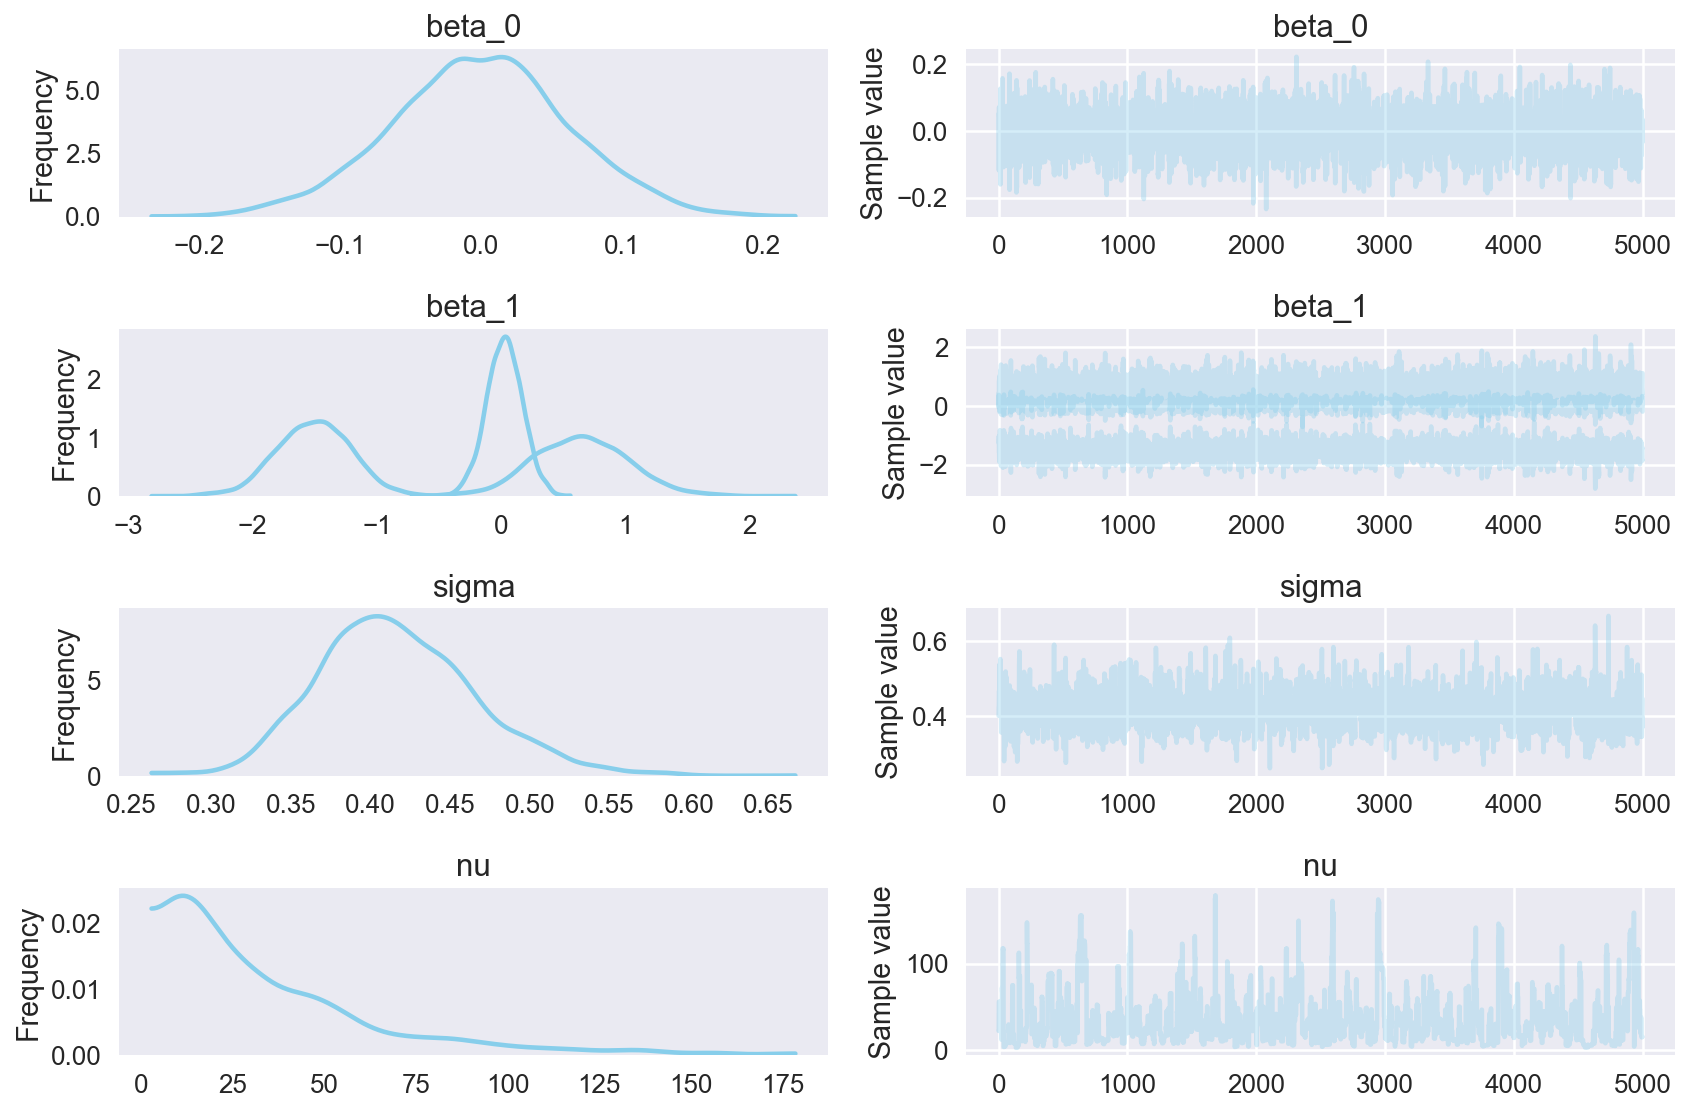

In [5]:
print(pm.df_summary(trace))
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x119e4ec50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x119d2b750>], dtype=object)

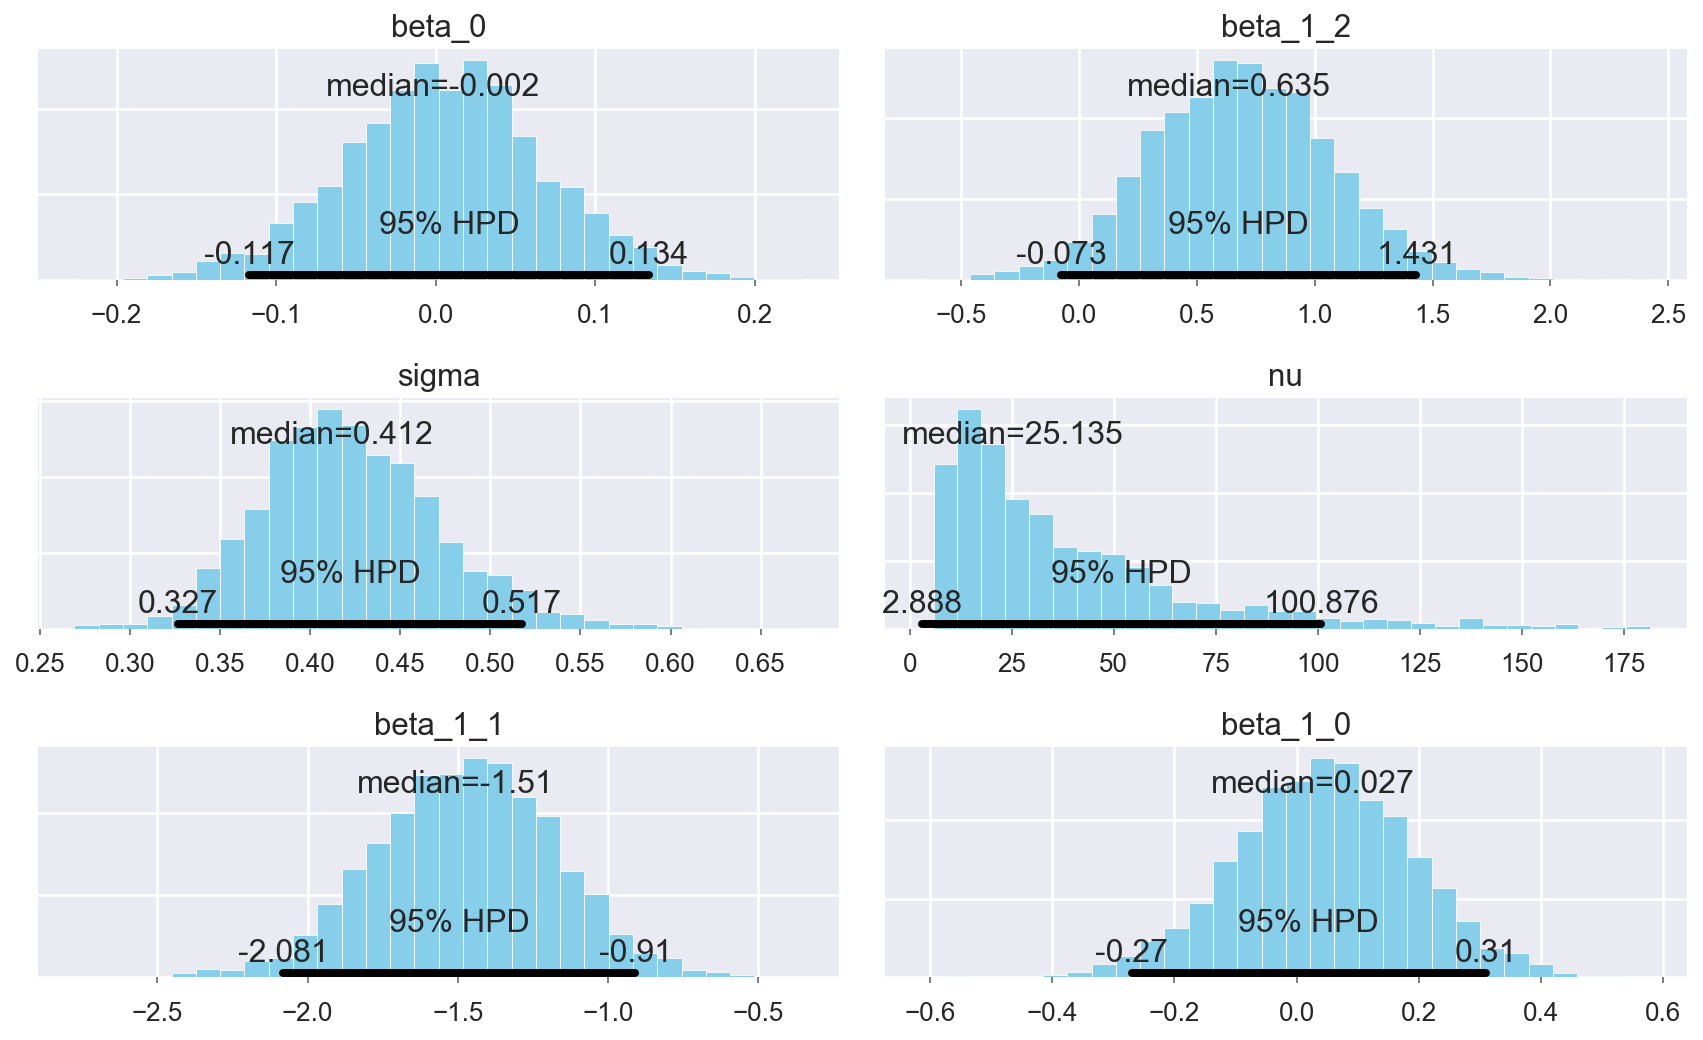

In [6]:
pm.plot_posterior(trace, point_estimate="median")

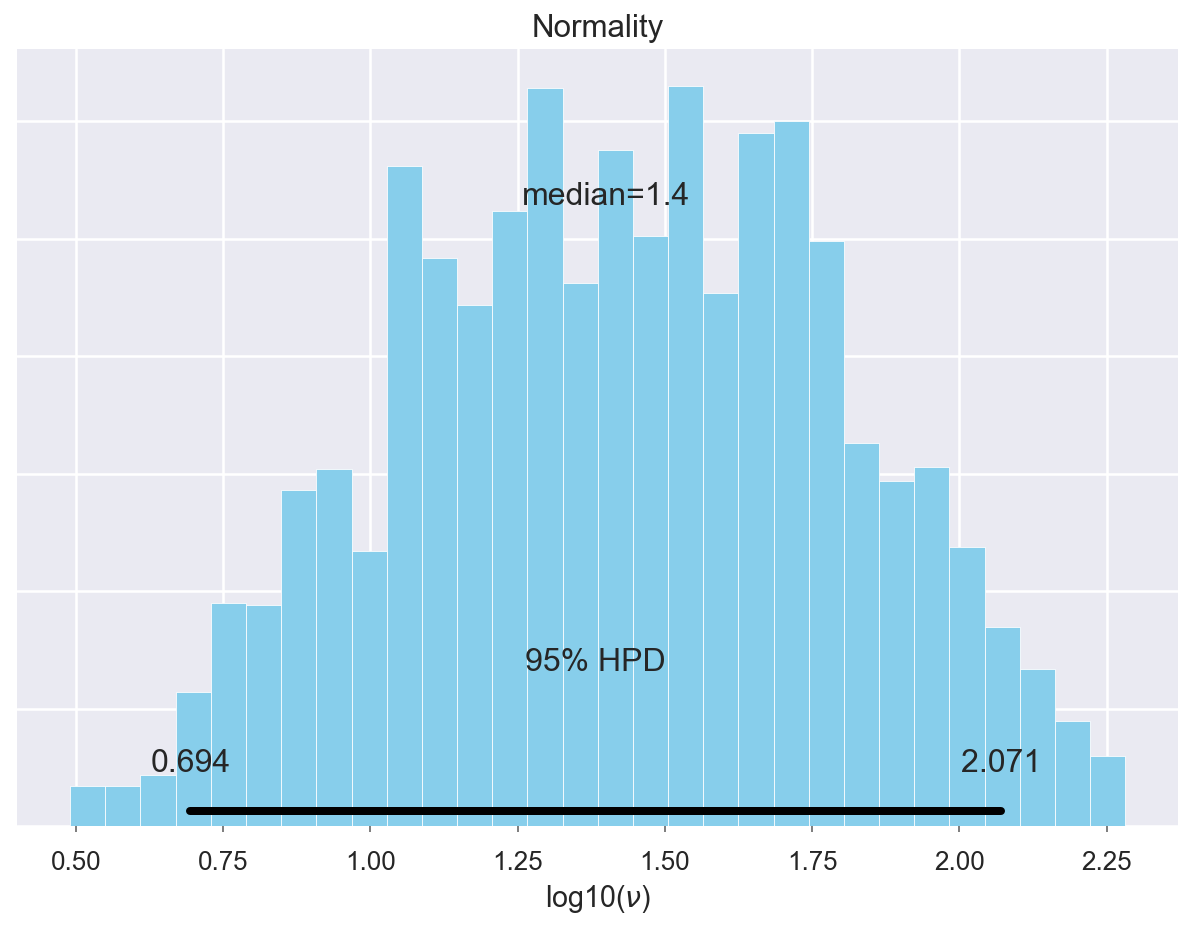

In [12]:
normality = np.log10(trace["nu"])
ax = pm.plot_posterior(normality, point_estimate="median")
ax.set_title("Normality")
ax.set_xlabel(r"log10($\nu$)")